In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Loading the behavioural/neural data

In [2]:
beh_data_dir = "data/COBAR_behaviour_incl_manual.pkl"
beh_data = pd.read_pickle(beh_data_dir)

In [3]:
neural_data_dir = beh_data_dir = "data/COBAR_neural.pkl"
neural_data = pd.read_pickle(neural_data_dir)

In [4]:
from scipy.signal import butter, filtfilt
def butter_lowpass_filter(data, cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data, axis=0)
    return y

#filter angles in beh data
fs=100.0
order=2
cutoff=20
beh_df = beh_data.copy(deep=True)
angl=beh_data.filter(regex="angle")
filtered_angl = butter_lowpass_filter(angl, cutoff, fs, order)
beh_df.iloc[:,2:44]=filtered_angl

#filter neurons reading in neural data
neural_df = neural_data.copy(deep=True) #necessary to deep copy dataframe
fs=16.0
order=2
cutoff=2.5
neurons=neural_data.filter(regex="neuron")
filtered_neurons = butter_lowpass_filter(neurons, cutoff, fs, order)
neural_df.iloc[:,1:124]=filtered_neurons

### FINAL DATASETS ARE neural_df & beh_df

## Part 1 : Plotting the data

### 1. Plot time traces of individual neurons across multiple trials

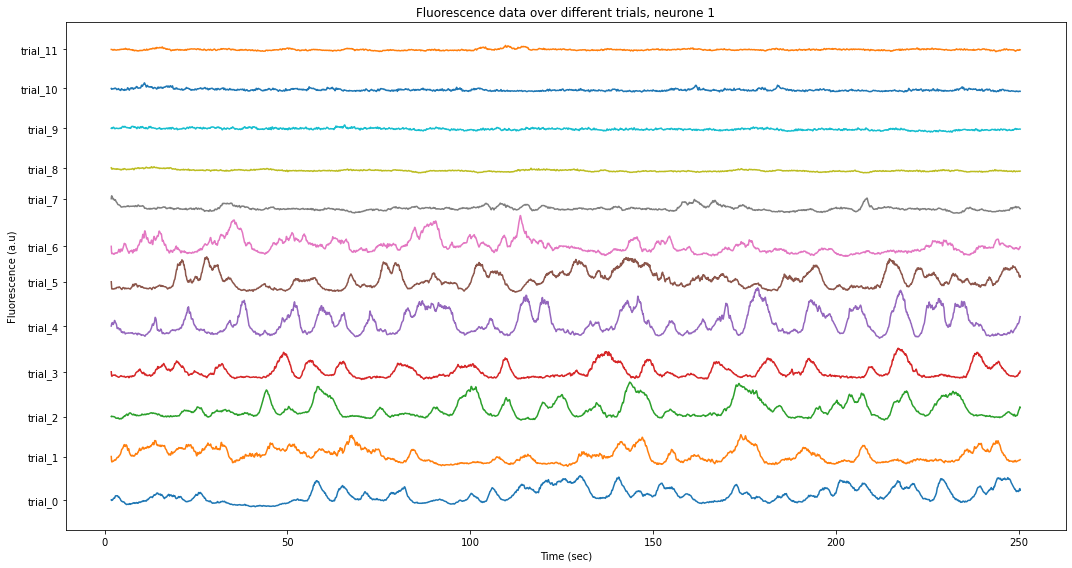

In [5]:
#Fluorescence data over different trials, neurone 1
neural_signals_neuron_1 = neural_df["neuron_1"]

# We construct a 3x3 matrix whose elements will be subplots depending on the column and row number they span
fig, ax1 = plt.subplots(figsize = (15,8))

ytick = []
for i in np.arange(12):   
    neural_signals_neuron_1_trial_i = neural_signals_neuron_1[neural_df.index.get_level_values("Trial")==i]
    #ax1.plot(neural_df["t"].iloc[:380], i*1500 + neural_signals_neuron_1_trial_i.iloc[:380], label = 'trial_' + str(i))
    ax1.plot(neural_df["t"].iloc[:4039], i*1500 + neural_signals_neuron_1_trial_i.iloc[:4039], label = 'trial_' + str(i))
    ytick.append(neural_signals_neuron_1_trial_i.iloc[0] + i*1500)
    
ax1.set_ylabel('Fluorescence (a.u)')
ax1.set_xlabel('Time (sec)')
ax1.set_title('Fluorescence data over different trials, neurone 1')

ax1.set_yticks(np.array(ytick))
neuron_names = ['trial_' + str(i) for i in range(12)]
ax1.set_yticklabels(neuron_names)


plt.tight_layout()
plt.show()
fig.savefig('report_images/w8_fluo_neurone1.png')

## Part 2: Data pre-processing

### 1. ΔF/F

In [9]:
#Δ𝐹/𝐹 = (F − Fb)/𝐹b , where Fb is the baseline fluorescence.
rlt_Df_f=neural_df.copy(deep=True)

for j in np.arange(123): 
    baseline = neural_df['neuron_' + str(j)].rolling(window=3).mean()
    rlt_Df_f['neuron_' + str(j)] = (neural_df['neuron_' + str(j)]-abs(baseline.min()))/abs(baseline.min())

## Week 10 : Part 1.1 Identifying correlations of individual neurons

Compute the mean activity of a neuron during different behaviours. average the neuron’s activity separately during walking, resting, and so on.
Hint 1: You could visualise the results as colours of a matrix with individual neurons on
one axis and behaviours on the other axis.
Hint 2: Standardising the neuronal time-series to have mean zero and unit variance (i.e.,
z-scoring) may help with the visualisation.

In [10]:
#step1 : standardization
std_Df_f = rlt_Df_f.copy()

for j in np.arange(123): 
    baseline = rlt_Df_f['neuron_' + str(j)].mean()
    std_Df_f['neuron_' + str(j)] = (rlt_Df_f['neuron_' + str(j)]-rlt_Df_f['neuron_' + str(j)].mean())/(rlt_Df_f['neuron_' + str(j)].std())

In [ ]:
def reduce_mean(values):
    return np.mean(values, axis=0)
def reduce_std(values):
    return np.std(values, axis=0)
def reduce_behaviour(values):
    """
    this is just a sketch for how to reduce behavioural classes. 
    It picks whatever behaviour occurs the most.
    The function handles the case when two behaviours are equally likely thanks to the chosen treshold,
    and assures, given that the values are always 6 or 7, that if 4/6 or 4/7 behaviour frames are not labelled the same way
    returns nan and the data is excluded.
    """
    unique_values, N_per_unique = np.unique(values, return_counts=True)
    i_max = np.argmax(N_per_unique)

    #threshold = 0.75
    threshold = 4 #this treshold shows more robustness then using the 3/4
    for idx, unique_value in enumerate(unique_values):
        if N_per_unique[idx] > threshold:
        #if N_per_unique[idx] > threshold * len(values):
            return unique_value
    return "nan"
# threshold = 0.75
# for idx, unique_value in enumerate(unique_values):
#     if N_per_unique[idx] > threshold * len(values):
#          return unique_value
#return None

def reduce_during_2p_frame(twop_index, values, function=reduce_mean):
    """
    Reduces all values occuring during the acquisition of a
    two-photon imaging frame to a single value using the `function` given by the user.
    Parameters
    ----------
    twop_index : numpy array
        1d array holding frame indices of one trial.
    values : numpy array
        Values upsampled to the frequency of ThorSync,
        i.e. 1D numpy array of the same length as
        `frame_counter` or 2D numpy array of the same length.
    function : function
        Function used to reduce the value,
        e.g. np.mean for 1D variables
    Returns
    -------
    reduced : numpy array
        Numpy array with value for each two-photon imaging frame.
    """
    
    if len(twop_index) != len(values):
        raise ValueError("twop_index and values need to have the same length.")
    if len(values.shape) == 1:
        values = np.expand_dims(values, axis=1) #basically puth them in a column
        squeeze = True
    else:
        squeeze = False
    N_samples, N_variables = values.shape
    
    index_unique = np.unique(twop_index)
    index_unique = np.delete(index_unique, index_unique==-9223372036854775808) #copy of it with the specified objects removed
    
    dtype = values.dtype
    if np.issubdtype(dtype, np.number):
        dtype = np.float
    else:
        dtype = np.object
    reduced = np.empty((len(index_unique), N_variables), dtype=dtype)

    for i, index in enumerate(index_unique):
        reduced[i] = function(values[twop_index==index, :])
        
    return np.squeeze(reduced) if squeeze else reduced


#create list for storing the index corresponding to the frame with nans
indx=[]
reduced=[]

#try out functions with beh categories
for j in range(0,12):
    twop_index = beh_df.loc[(210301, "J1xCI9",1,j), "twop_index"].to_numpy()
    values = beh_df.loc[(210301, "J1xCI9",1,j), "Manual"].to_numpy()
    reduced.append(reduce_during_2p_frame(twop_index, values, function=reduce_behaviour))
    indx.append(np.where(reduced[j] =='nan'))
    reduced[j] = reduced[j][reduced[j] != 'nan']
    
#reorganize dataframe in order to remove the rows where the downsampling function gives nan as output with the 
#corresponding neuronal acitvity values across all the neurons
filtered_neurons_df=filtered_neural_df.copy(deep=True) #just be sure in case to rerun previous cells in the notebooks
#that original dataframe is not affected
filtered_neurons_df

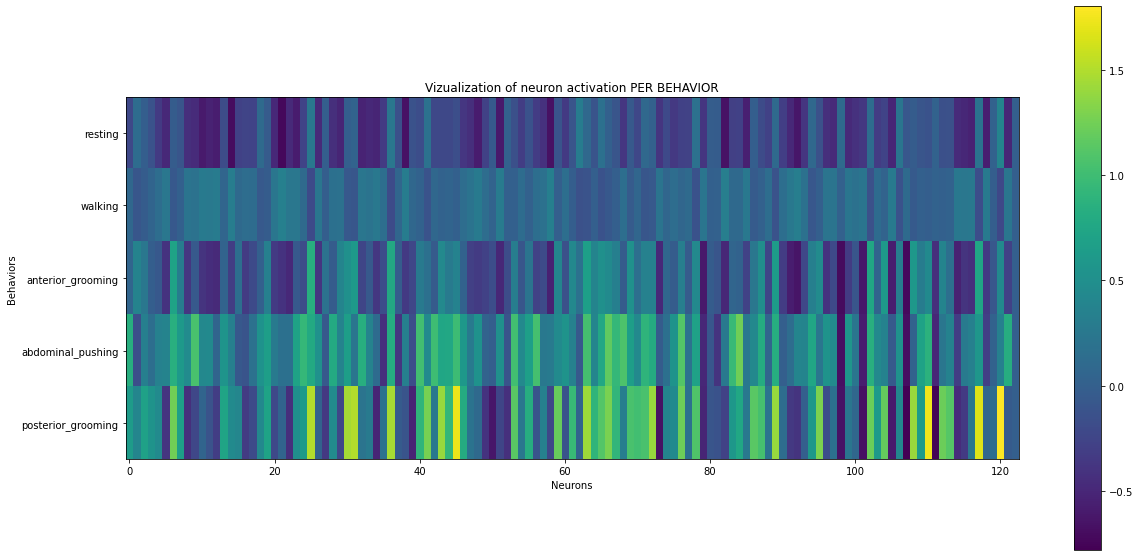

In [11]:
#step2 : vizualization of neuron activation PER BEHAVIOR

#get manual labelling of behaviors
std_Df_f['Manual'] = beh_df['Manual']
behaviors = ['resting', 'walking', 'anterior_grooming', 'abdominal_pushing', 'posterior_grooming']
ytick=[0,1,2,3,4]
val = np.zeros((5,123))

for i in range (len(behaviors)):
    b = behaviors[i]
    behavior_data = std_Df_f[std_Df_f['Manual']==b]
    behavior_data
    for j in range (122):
        val[i,j]=behavior_data['neuron_' + str(j)].mean()

fig, ax2 = plt.subplots(figsize = (20,10))
ax2.set_yticks(ytick)
ax2.set_yticklabels(behaviors)
ax2.set_title('Vizualization of neuron activation PER BEHAVIOR')
ax2.set_ylabel('Behaviors')
ax2.set_xlabel('Neurons')
plt.imshow(val, aspect=10)
plt.colorbar()
plt.show()
fig.savefig('report_images/neuron_act_per_behavior.png')

### try to plot for some particular neurons where identification of behavior involved is easy to recognize
 1. abdominal pushing


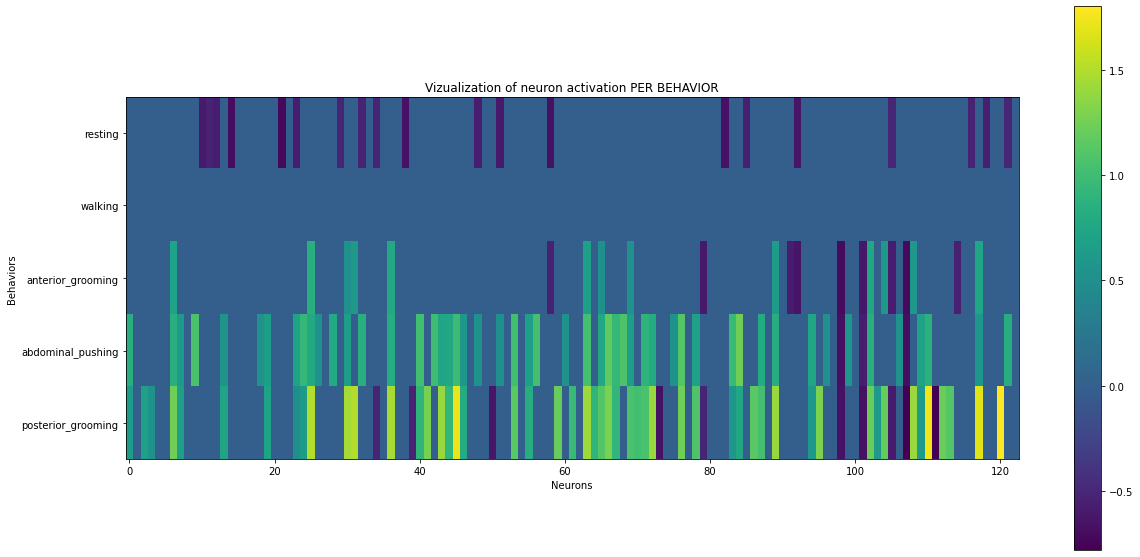

In [12]:
treshold=0.5
#get neurons with anormal activation/unactivation in behaviors
anormal = val.copy()
for i in range (len(behaviors)):
    for j in range (122):
        if (anormal[i,j] < treshold) and (anormal[i,j] > -treshold):
            anormal[i,j] = 0

#plot
fig, ax2 = plt.subplots(figsize = (20,10))
ax2.set_yticks(ytick)
ax2.set_yticklabels(behaviors)
ax2.set_title('Vizualization of neuron activation PER BEHAVIOR')
ax2.set_ylabel('Behaviors')
ax2.set_xlabel('Neurons')
plt.imshow(anormal, aspect=10)
plt.colorbar()
plt.show()
fig.savefig('report_images/neuron_act_per_behavior.png')

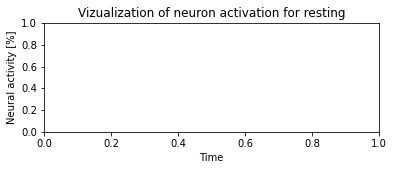

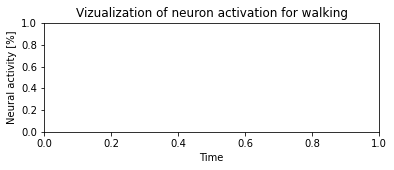

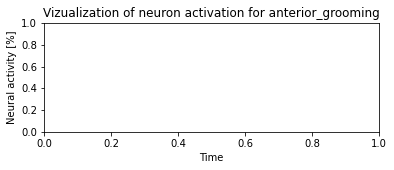

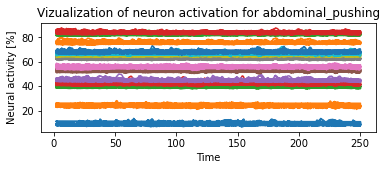

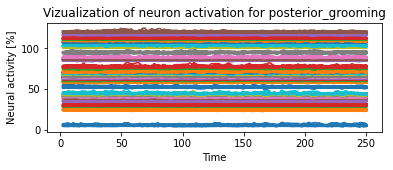

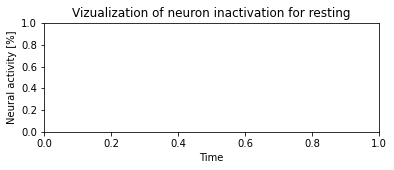

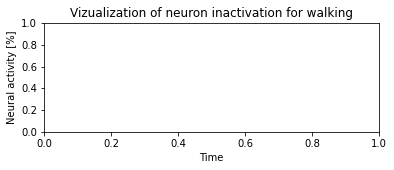

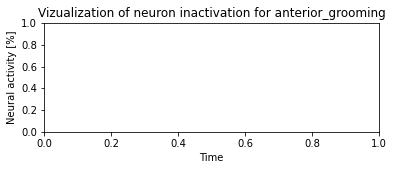

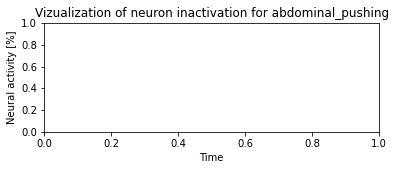

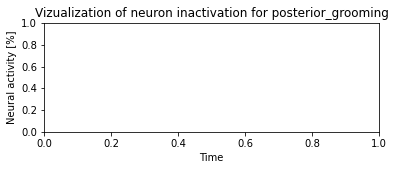

In [13]:
#plots activation for each behaviors
treshold=0.9
#get neurons with anormal activation/unactivation in behaviors
plots_act= val.copy()
plots_inact= val.copy()
for i in range (len(behaviors)):
    for j in range (122):
        if (plots_act[i,j] < treshold):
            plots_act[i,j] = 0
        if (plots_inact[i,j] > -treshold):
            plots_inact[i,j] = 0
            
for i in range (len(behaviors)):  
    #try to isolate one behavior for each neuron
    name_fig='fig_beh_'+str(i)
    name_ax='ax_'+str(i)
    name_fig, name_ax = plt.subplots(figsize = (6,2))
    for j in range (122):
        if plots_act[i,j]>0.0 :
            plt.plot(std_Df_f['t'], std_Df_f['neuron_'+ str(j)]+j)
    name_ax.set_title('Vizualization of neuron activation for ' + behaviors[i])
    name_ax.set_ylabel('Neural activity [%]')
    name_ax.set_xlabel('Time')
    plt.show()

for i in range (len(behaviors)):  
    #try to isolate one behavior for each neuron
    name_fig='fig_beh_'+str(i)
    name_ax='ax_'+str(i)
    name_fig, name_ax = plt.subplots(figsize = (6,2))    
    for j in range (122):
        if plots_inact[i,j]<0.0 :
            plt.plot(std_Df_f['t'], std_Df_f['neuron_'+ str(j)]+j)
    name_ax.set_title('Vizualization of neuron inactivation for ' + behaviors[i])
    name_ax.set_ylabel('Neural activity [%]')
    name_ax.set_xlabel('Time')
    plt.show()

In [14]:
#getting 5 more implicated neurons 
plots_act= val.copy()
nbr_required_neurons=123
neurons= np.zeros((5,nbr_required_neurons))
for i in range (len(behaviors)):
    for j in range (nbr_required_neurons):
        index_max=(np.int_((np.where(abs(plots_act[i])==abs(plots_act[i]).max()))))[0,0]
        neurons[i,j]=index_max
        plots_act[i,index_max]=0
neurons=np.int_(neurons)

In [20]:
neurons[0].where(neurons[0]==21)

AttributeError: 'numpy.ndarray' object has no attribute 'where'

/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards

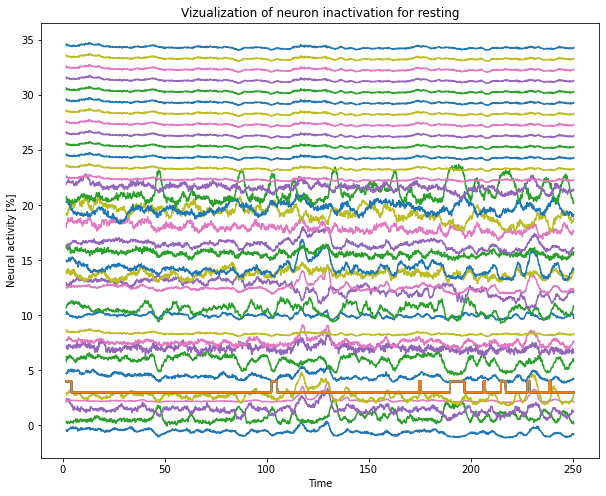

/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards

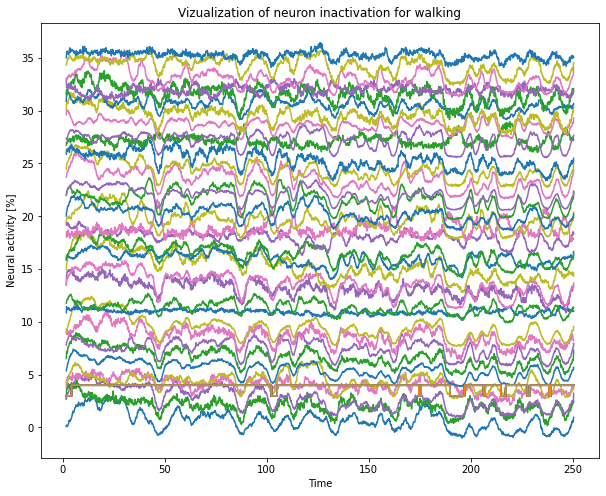

/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards

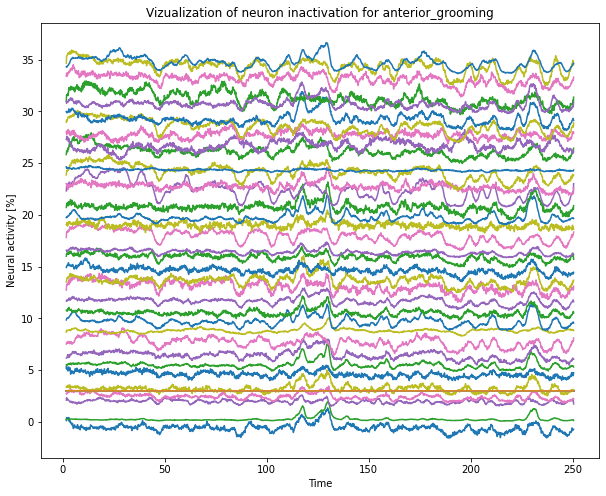

/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards

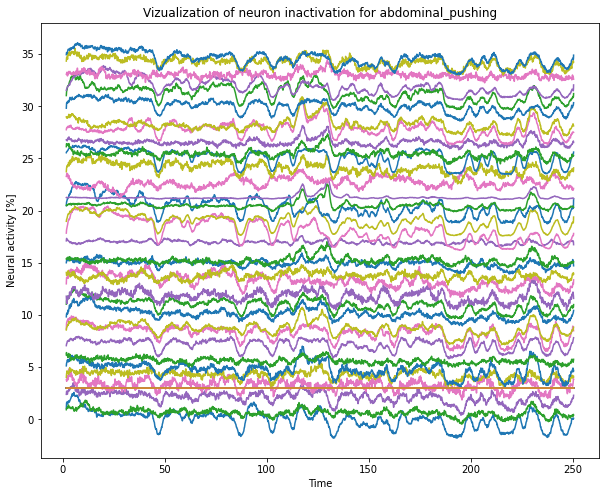

/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards

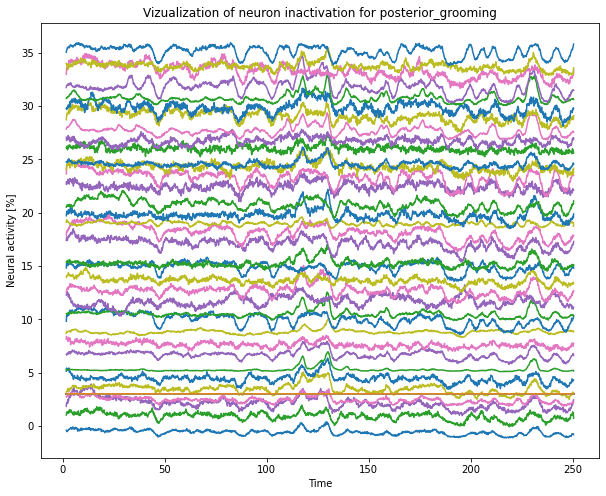

In [17]:
from scipy.signal import *

#try for a specific trial, otherwise it's getting complicated
try_trial = std_Df_f[std_Df_f.index.get_level_values("Trial")==8].copy(deep=True)
indexs_beh=[]
for i in range (len(neurons)):  
    #try to isolate one behavior for each neuron
    name_fig='fig_beh_'+str(i)
    name_ax='ax_'+str(i)
    name_fig, name_ax = plt.subplots(figsize = (10,8))
    
    for j in range (len(neurons[1])):
        plot_beh=np.zeros((len(try_trial['t'])))
        indexs_beh= np.where(try_trial['Manual']==behaviors[i])
        plot_beh[indexs_beh] = 4    
        indexs_= np.where(try_trial['Manual']!=behaviors[i])
        plot_beh[indexs_] = 3 
        plt.plot(try_trial['t'], j+hilbert(try_trial['neuron_'+str(neurons[i,j])]))
        plt.plot(try_trial['t'], plot_beh)
    name_ax.set_title('Vizualization of neuron inactivation for ' + behaviors[i])
    name_ax.set_ylabel('Neural activity [%]')
    name_ax.set_xlabel('Time')
    #name_ax.legend('neuron_'+str(neurons[i,0]), 'neuron_'+str(neurons[i,1]))
    plt.show()

### CORRELATION MATRIX

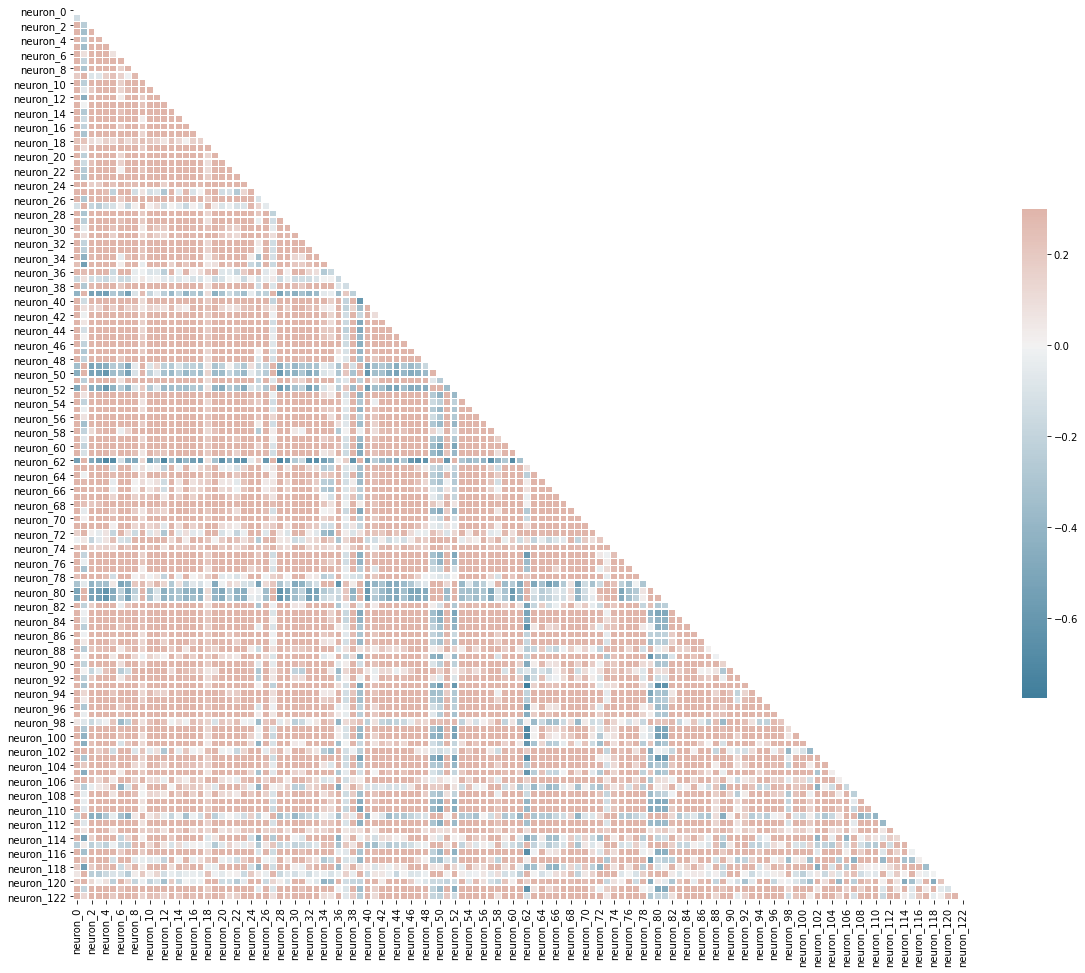

In [18]:
import seaborn as sns
#Compute the correlation matrix
correlation = std_Df_f.drop('t', axis=1).drop('Manual', axis=1).copy(deep = True)

corr = correlation.corr()

#Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

#Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 18))

#Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

#Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
f.savefig('report_images/correlation.png')

In [19]:
#reduction of correlation matrix
treshold = 0.85
i = corr[((corr > treshold)) | (corr < -treshold) ].fillna(0)
i = i[i<1.0]
i = i[i>-1.0]
new = i**2
new[new.isnull()==True]=0
sumnew=new.sum(axis=0)
ind_=sumnew[sumnew>1]
ind_=ind_.index[1:]
final=correlation.drop(ind_,axis=1)
final

neuron_0  neuron_1  neuron_2  neuron_8  \
Date   Genotype Fly Trial Frame                                           
210301 J1xCI9   1   0     0     -0.801239 -0.185117 -1.109675 -0.867977   
                          1     -0.758209 -0.224993 -1.108455 -0.923203   
                          2     -0.747117 -0.238943 -1.117427 -0.964147   
                          3     -0.772595 -0.209213 -1.139302 -0.987765   
                          4     -0.801670 -0.164552 -1.164653 -0.990995   
...                                   ...       ...       ...       ...   
                    11    4035  -0.408414 -1.146542  0.408975  1.476816   
                          4036  -0.430328 -1.125685  0.383745  1.482535   
                          4037  -0.427361 -1.125539  0.376445  1.434240   
                          4038  -0.381362 -1.154629  0.422920  1.332860   
                          4039  -0.303169 -1.203873  0.521997  1.194743   

                                 neuron_9  neuron_11  neuron_13  neuron_14  \
Date   Genotype Fly Trial Frame                                              
210301 J1xCI9   1   0     0     -0.338251  -0.879117  -1.180400  -1.138059   
                          1     -0.409125  -0.915650  -1.043476  -1.102324   
                          2     -0.461920  -0.950082  -0.965877  -1.086504   
                          3     -0.488969  -0.952806  -0.956634  -1.095287   
                          4     -0.498028  -0.901526  -0.981493  -1.117574   
...                                   ...        ...        ...        ...   
                    11    4035  -0.121458   0.968352  -0.637868   0.508858   
                          4036  -0.109683   0.842579  -0.386941   0.475465   
                          4037  -0.122307   0.690607  -0.155960   0.433697   
                          4038   0.047803   0.498739  -0.054173   0.427610   
                          4039   0.432803   0.275606  -0.034425   0.464116   

                                 neuron_15  neuron_16  ...  neuron_109  \
Date   Genotype Fly Trial Frame                        ...               
210301 J1xCI9   1   0     0      -0.957376  -1.289221  ...   -0.902522   
                          1      -0.895037  -1.236303  ...   -0.885452   
                          2      -0.850787  -1.219247  ...   -0.885280   
                          3      -0.820046  -1.235928  ...   -0.908264   
                          4      -0.784552  -1.257267  ...   -0.947190   
...                                    ...        ...  ...         ...   
                    11    4035   -1.343358   1.198373  ...   -0.831727   
                          4036   -1.327585   1.238559  ...   -0.809608   
                          4037   -1.283096   1.278121  ...   -0.795292   
                          4038   -1.279062   1.287185  ...   -0.778591   
                          4039   -1.324928   1.261324  ...   -0.751257   

                                 neuron_111  neuron_112  neuron_113  \
Date   Genotype Fly Trial Frame                                       
210301 J1xCI9   1   0     0        2.856502   -0.792817    2.134921   
                          1        2.717031   -0.776910    1.983695   
                          2        2.591750   -0.766302    1.851133   
                          3        2.502965   -0.767091    1.761120   
                          4        2.471194   -0.782255    1.715664   
...                                     ...         ...         ...   
                    11    4035     0.276971   -1.627042   -0.663282   
                          4036     0.343410   -1.548836   -0.570469   
                          4037     0.396320   -1.489038   -0.347361   
                          4038     0.378052   -1.523176   -0.145736   
                          4039     0.294534   -1.647439   -0.001507   

                                 neuron_114  neuron_115  neuron_118  \
Date   Genotype Fly Trial Frame                                       
210301 J1xCI9

In [22]:
### correlation between neural data and behavioral data
from scipy import stats
nbr_neurons = 122
nbr_beh_param = beh_data.filter(regex='angle').columns
correlation = neurons= np.zeros((len(nbr_beh_param),nbr_neurons))

#DONE ONLY FOR TRIAL 0
for j in range (len(nbr_beh_param)): 
    twop_index = beh_df[beh_df.index.get_level_values('Trial')==0]['twop_index'].to_numpy()
    values = beh_df.loc[(210301, 'J1xCI9', 1, 0), nbr_beh_param[j]].to_numpy()
    angl_DS = reduce_during_2p_frame(twop_index, values, function=reduce_mean)  
    for i in range (nbr_neurons) : 
        a=stats.spearmanr(std_Df_f['neuron_'+str(i)][std_Df_f.index.get_level_values('Trial')==0], angl_DS) 
        correlation[j,i]=a[0]

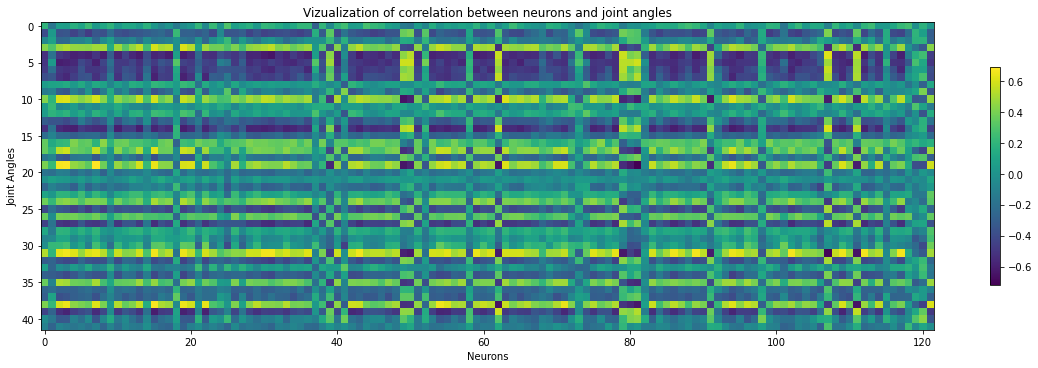

In [23]:
#plot
fig, ax2 = plt.subplots(figsize = (20,40))
ax2.set_title('Vizualization of correlation between neurons and joint angles')
ax2.set_ylabel('Joint Angles')
ax2.set_xlabel('Neurons')
plt.imshow(correlation)
plt.colorbar(shrink=0.1)
plt.show()
fig.savefig('report_images/neuron_act_per_behavior.png')

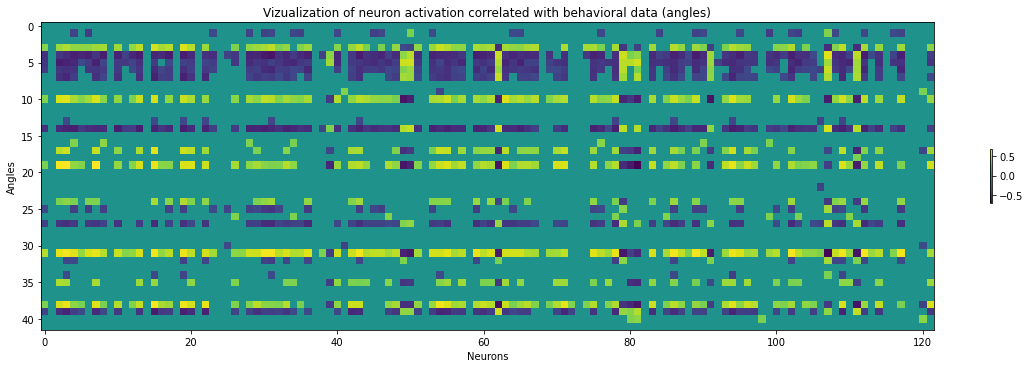

In [24]:
treshold=0.4
#get neurons with anormal activation/unactivation in behaviors
special =  correlation.copy()
for i in range (len(correlation)):
    for j in range (122):
        if (special[i,j] < treshold) and (special[i,j] > -treshold):
            special[i,j] = 0

#plot
fig, ax2 = plt.subplots(figsize = (20,10))
ax2.set_title('Vizualization of neuron activation correlated with behavioral data (angles)')
ax2.set_ylabel('Angles')
ax2.set_xlabel('Neurons')
plt.imshow(special)
plt.colorbar(shrink=0.1)
plt.show()
fig.savefig('report_images/correlation_neuron_act_behavioral_data.png')

In [25]:
index_max=(np.int_((np.where(correlation[4]==correlation[4].min()))))[0,0]
index_max

31

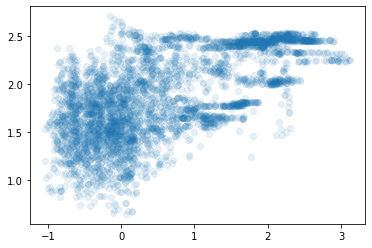

In [26]:
twop_index = beh_df[beh_df.index.get_level_values('Trial')==0]['twop_index'].to_numpy()
values = beh_df.loc[(210301, 'J1xCI9', 1, 0), nbr_beh_param[4]].to_numpy()
angl_DS = reduce_during_2p_frame(twop_index, values, function=reduce_mean)
plt.scatter(std_Df_f['neuron_'+str(107)][std_Df_f.index.get_level_values('Trial')==0], angl_DS, alpha = 0.1)

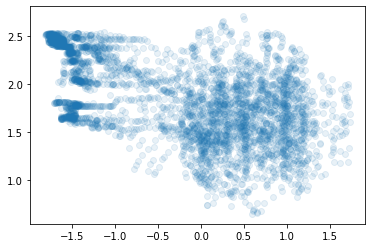

In [27]:
twop_index = beh_df[beh_df.index.get_level_values('Trial')==0]['twop_index'].to_numpy()
values = beh_df.loc[(210301, 'J1xCI9', 1, 0), nbr_beh_param[4]].to_numpy()
angl_DS = reduce_during_2p_frame(twop_index, values, function=reduce_mean)
plt.scatter(std_Df_f['neuron_'+str(4)][std_Df_f.index.get_level_values('Trial')==0], angl_DS, alpha = 0.1)

### RESULTS FROM CLUSTERISATION FROM HILA

In [81]:
from numpy.linalg import norm
import random
w_norm= [1, 2, 0, 1, 1, 4, 0, 0, 4, 2, 4, 4, 4, 0, 4, 1, 4, 1, 3, 0, 4, 4,
       4, 1, 3, 3, 4, 2, 1, 1, 0, 0, 1, 1, 4, 4, 3, 2, 4, 2, 0, 3, 1, 0,
       0, 0, 1, 1, 4, 2, 2, 4, 2, 0, 1, 0, 1, 1, 4, 0, 1, 0, 2, 3, 0, 3,
       3, 3, 3, 0, 0, 3, 3, 2, 2, 1, 0, 1, 3, 2, 2, 2, 4, 1, 1, 4, 0, 0,
       4, 0, 4, 4, 4, 1, 0, 0, 4, 4, 2, 1, 1, 4, 3, 1, 0, 4, 3, 4, 0, 0,
       0, 2, 0, 3, 4, 2, 4, 3, 4, 2, 3, 4, 0]
compare=[]
compare.append([i for i, n in enumerate(w_norm) if n == 0])
compare.append([i for i, n in enumerate(w_norm) if n == 1])
compare.append([i for i, n in enumerate(w_norm) if n == 2])
compare.append([i for i, n in enumerate(w_norm) if n == 3])
compare.append([i for i, n in enumerate(w_norm) if n == 4])

In [102]:
len(val[1])

30

In [120]:
compare[0]

[2,
 6,
 7,
 13,
 19,
 30,
 31,
 40,
 43,
 44,
 45,
 53,
 55,
 59,
 61,
 64,
 69,
 70,
 76,
 86,
 87,
 89,
 94,
 95,
 104,
 108,
 109,
 110,
 112,
 122]

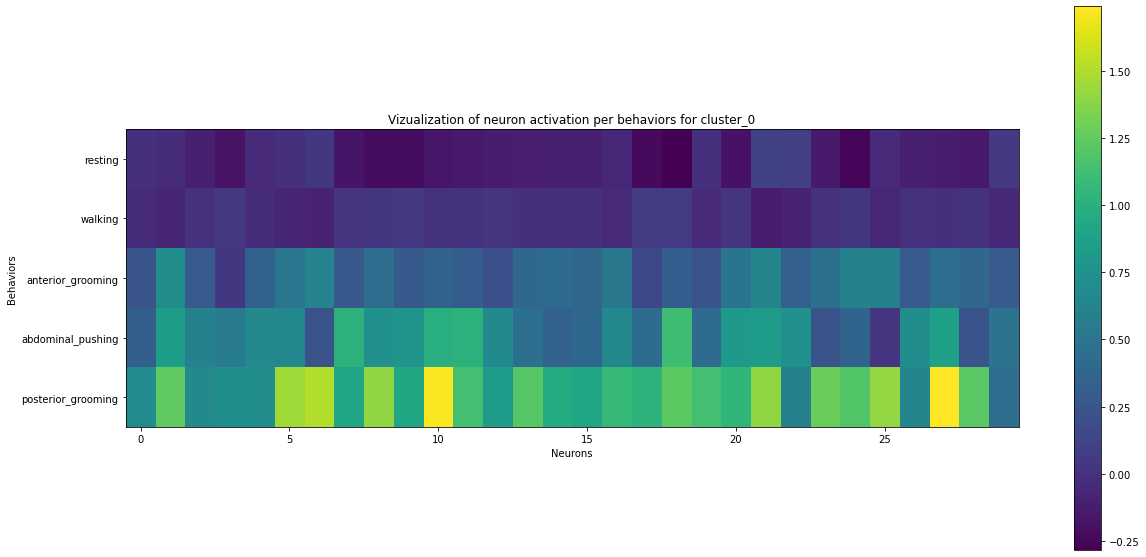

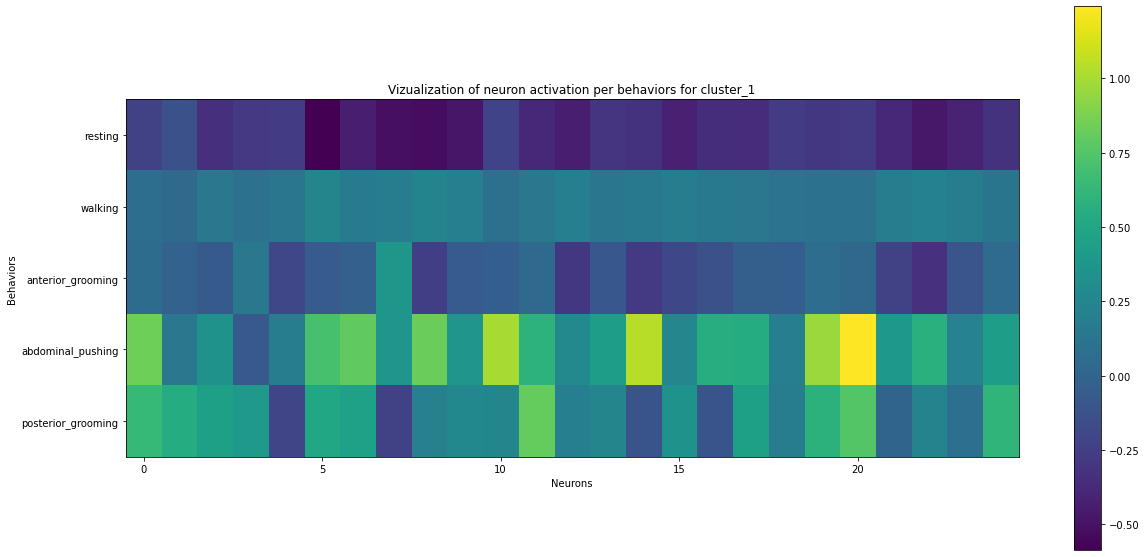

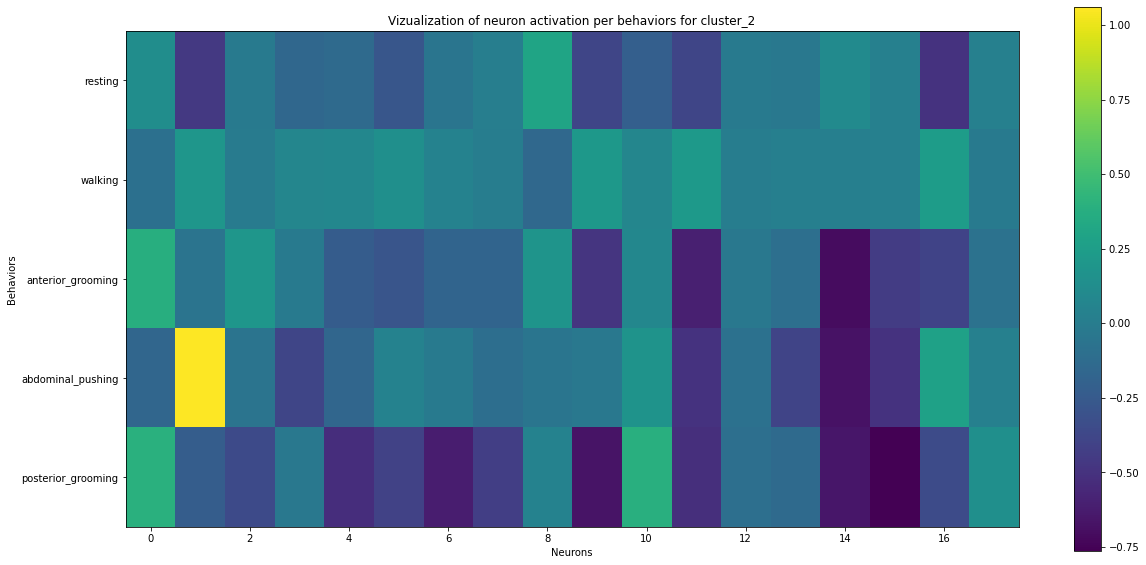

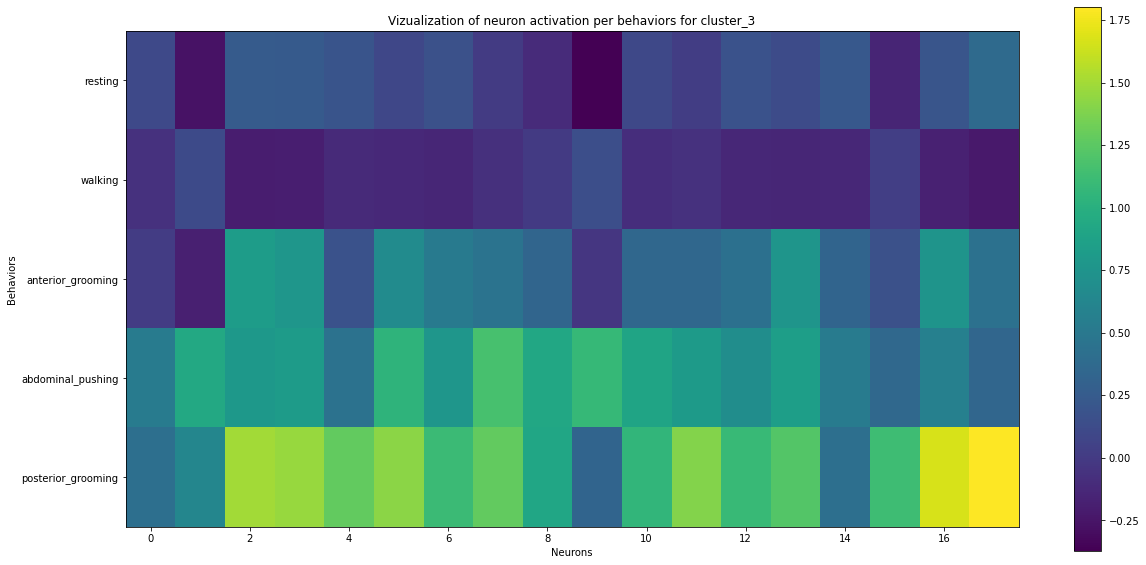

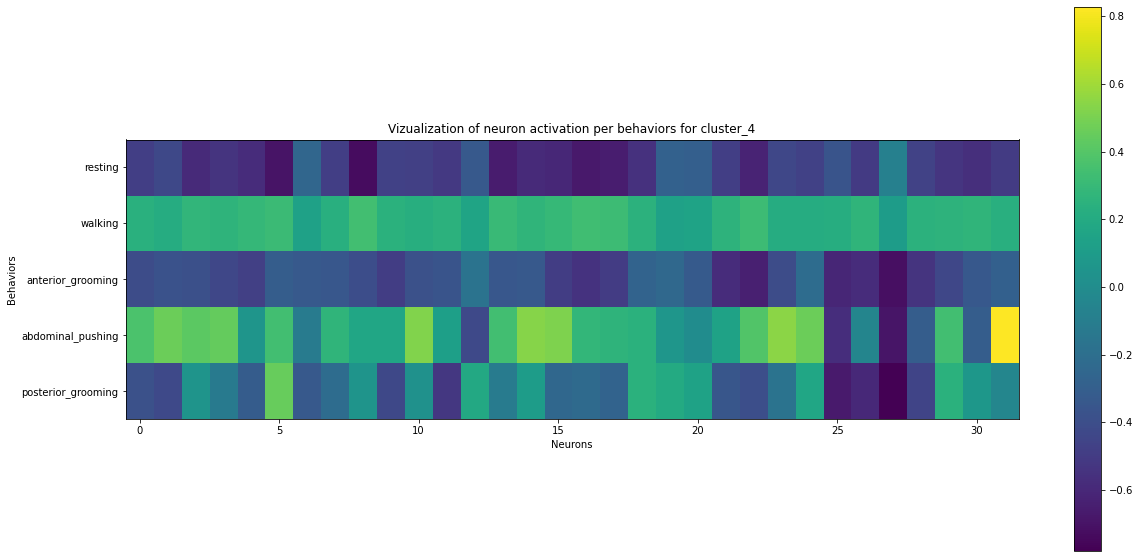

In [124]:
#step2 : vizualization of neuron activation PER BEHAVIOR
#get manual labelling of behaviors
behaviors = ['resting', 'walking', 'anterior_grooming', 'abdominal_pushing', 'posterior_grooming']
ytick=[0,1,2,3,4]

for k in range (5):
    val = np.zeros((5,len(compare[k])))
    i=0
    j=0
    #get corresponding neurons
    for i in range (len(behaviors)):
        behavior_data = std_Df_f[std_Df_f['Manual']==behaviors[i]]
        for j in range (len(val[i])):
            val[i,j] = behavior_data['neuron_' + str(compare[k][j])].mean()
    
    name='fig_cluster_'+str(k)
    name_ax='fig_ax_'+str(k)
    name, name_ax = plt.subplots(figsize = (20,10))
    name_ax.set_yticks(ytick)
    name_ax.set_yticklabels(behaviors)
    name_ax.set_title('Vizualization of neuron activation per behaviors for cluster_'+str(k))
    name_ax.set_ylabel('Behaviors')
    name_ax.set_xlabel('Neurons')
    plt.imshow(val, aspect=2)
    plt.colorbar()
    plt.show()
    name.savefig('report_images/neuron_act_per_behavior.png')

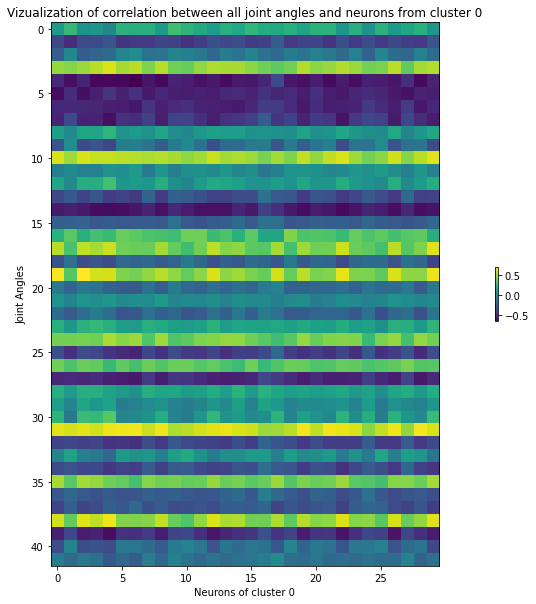

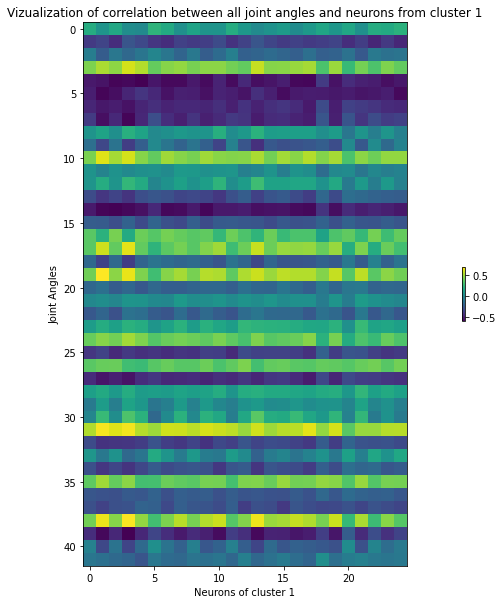

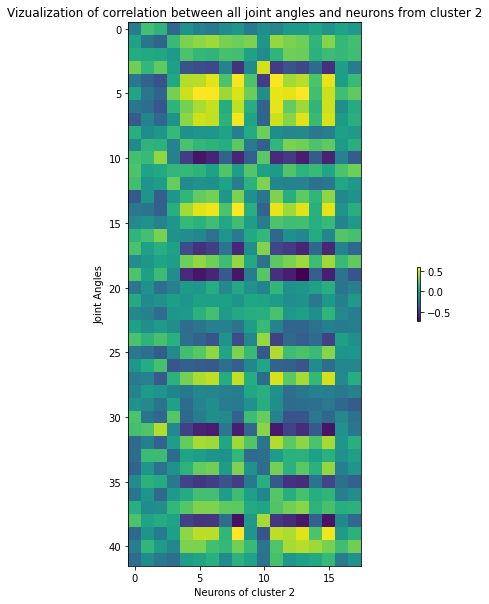

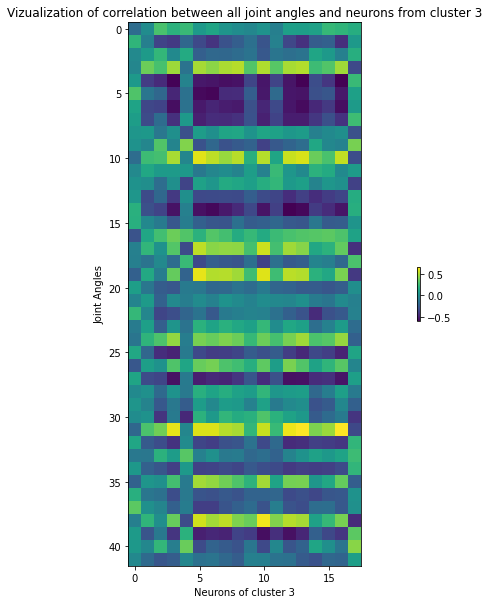

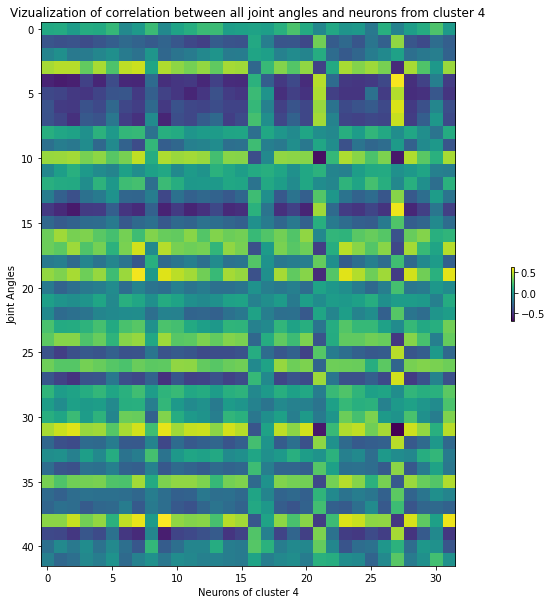

In [129]:
#step2 : vizualization of neuron activation PER BEHAVIOR
#get manual labelling of behaviors
from scipy import stats

for k in range (5):
    val = np.zeros((5,len(compare[k])))
    
    ### correlation between neural data and behavioral data
    nbr_beh_param = beh_data.filter(regex='angle').columns
    correlation = np.zeros((len(nbr_beh_param),len(compare[k])))

    #DONE ONLY FOR TRIAL 0
    for i in range (len(nbr_beh_param)): 
        twop_index = beh_df[beh_df.index.get_level_values('Trial')==0]['twop_index'].to_numpy()
        values = beh_df.loc[(210301, 'J1xCI9', 1, 0), nbr_beh_param[i]].to_numpy()
        angl_DS = reduce_during_2p_frame(twop_index, values, function=reduce_mean)  
        for j in range (len(compare[k])) : 
            a=stats.spearmanr(std_Df_f['neuron_'+str(compare[k][j])][std_Df_f.index.get_level_values('Trial')==0], angl_DS) 
            correlation[i,j]=a[0]
    #plot
    name='fig_cluster_'+str(k)
    name_ax='fig_ax_'+str(k)
    name, name_ax = plt.subplots(figsize = (20,10))
    name_ax.set_title('Vizualization of correlation between all joint angles and neurons from cluster '+str(k))
    name_ax.set_ylabel('Joint Angles')
    name_ax.set_xlabel('Neurons of cluster '+str(k))
    plt.imshow(correlation)
    plt.colorbar(shrink=0.1)
    plt.show()
    name.savefig('report_images/corr_btw_joint_angles_neuron_cluster'+str(k)+'.png')

1. investiguate in non-stable neurons
2. investiguate non-often firing neurons
3. investiguate
df.filter(regex=“neuron”)